# Reactor Physics Data Set

**Inputs**: 2-group homogenized cross sections (HXS) ($cm^{-1}$)

- `FissionFast`: $\nu\Sigma_f^1$
- `CaptureFast`: $\Sigma_a^1$
- `FissionThermal`: $\nu\Sigma_f^2$
- `CaptureThermal`: $\Sigma_a^2$
- `Scatter12`: $\Sigma_s^{1 \rightarrow 2}$
- `Scatter11`: $\Sigma_s^{1 \rightarrow 1}$
- `Scatter21`: $\Sigma_s^{2 \rightarrow 1}$
- `Scatter22`: $\Sigma_s^{2 \rightarrow 2}$

**Outputs**

- `k`: Neutron multipulcation factor

This data set consists of 1000 observations with 8 inputs and 1 output. The data is taken from [1], a sensitivity analysis using the Shapley effect. The geometry of the problem is a pressurized water reactor (PWR) lattice based on the BEAVRS benchmark. The lattice is a $17 \times 17$ PWR with 264 $UO_2$ fuel rods, 24 guide tubes, and one instrumentation tube. The lattice utilizes quarter symmetry in TRITON and is depleted to 50 GWD/MTU. To construct the data set a two-step process was used: (1) the uncertainty in the fundamental microscopic XS data was propogated and (2) these XSs were collapsed into a 2-group form using the following equation

\begin{equation}
    \Sigma_x^g = \frac{\int_{\Delta E_g}dE \int_V \Sigma_{x,m}(E) \phi(r,E,t) dV}{\int_{\Delta E_g}dE\int_V\phi(r,E,t)dV}.
\end{equation}

The Sampler module in SCALE was used for uncertainty propagation and the 56-group XS and covariance libraries were used in TRITON to create 56-group HXSs using the above equation. These HXSs are then collapsed to a 2-group library. 1000 random samples were taken from the Sampler.

In [6]:
import pyMAISE as mai
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import uniform, randint
from sklearn.model_selection import ShuffleSplit

# Plot settings
matplotlib_settings = {
    "font.size": 14,
    "legend.fontsize": 12,
}
plt.rcParams.update(**matplotlib_settings)

## pyMAISE Initialization

pyMAISE will be initialized with the following global settings:

- `verbosity`: 0 $\rightarrow$ pyMAISE prints no outputs,
- `random_state`: None $\rightarrow$ no random seed is set,
- `test_size`: 0.3 $\rightarrow$ 30% of the data is used for testing,
- `num_configs_saved`: 5 $\rightarrow$ the top 5 hyper-parameter configurations are saved for each model.

We can load the reactor physics pre-processor by `load_xs()`.

In [7]:
global_settings = mai.settings.init()
preprocessor = mai.load_xs()

The data consists of 8 inputs:

In [8]:
preprocessor.inputs.head()

,FissionFast,CaptureFast,FissionThermal,CaptureThermal,Scatter12,Scatter11,Scatter21,Scatter22
0,0.006446,0.009248,0.130007,0.080836,0.014973,0.482483,0.001506,1.12546
1,0.006359,0.009347,0.128811,0.081048,0.015363,0.490558,0.001497,1.12616
2,0.006467,0.009253,0.129465,0.080762,0.015198,0.486784,0.001493,1.12423
3,0.006479,0.009258,0.130903,0.081478,0.015345,0.492895,0.001516,1.13075
4,0.006431,0.009248,0.129757,0.081129,0.015216,0.488249,0.001506,1.12731


and one output with 1000 data points:

In [9]:
preprocessor.outputs.head()

,k
0,1.256376
1,1.241534
2,1.256988
3,1.261442
4,1.253744


To get a better idea of the data we can create a corrilation matrix using the `correlation_matrix()` function.

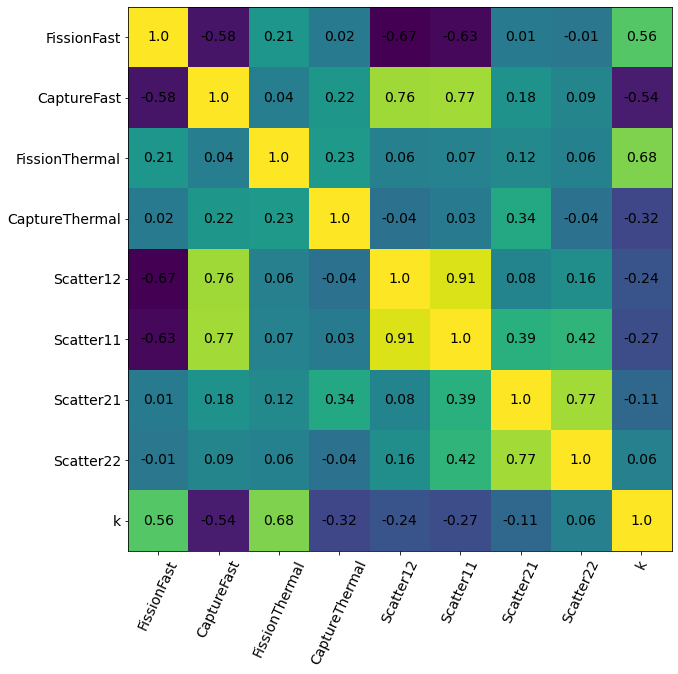

In [10]:
fig, ax = plt.subplots(figsize=(15,10))
fig, ax = preprocessor.correlation_matrix(fig=fig, ax=ax, colorbar=False, annotations=True)

There is a positive correlation between `k` with `FissionFast` and `FissionThermal`.

The last step of initialization is scaling, we will min-max scale this data.

In [11]:
data = preprocessor.min_max_scale()

## Model Initialization

As this data set had a 1-dimensional output, we will hyper-parameter 7 models:

- Linear regression: `linear`,
- Lasso regression: `lasso`,
- Support vector regression: `svr`,
- Decision tree regression: `dtree`,
- Random forest regression: `rforest`,
- K-nearest neighbors regression: `knn`,
- Sequential Dense Neural Networks: `nn`.

All the classical models are initialized with the Scikit-learn defaults; however, the neural networks require some paramter definitions for the layers, optimizer, and training.

In [12]:
model_settings = {
    "models": ["linear", "lasso", "dtree", "svr", "knn", "rforest", "nn"],
    "nn": {
        # Sequential
        "num_layers": 4,
        "dropout": True,
        "rate": 0.5,
        "validation_split": 0.15,
        "loss": "mean_absolute_error",
        "metrics": ["mean_absolute_error"],
        "batch_size": 8,
        "epochs": 50,
        "warm_start": True,
        "jit_compile": False,
        # Starting Layer
        "start_num_nodes": 100,
        "start_kernel_initializer": "normal",
        "start_activation": "relu",
        "input_dim": preprocessor.inputs.shape[1], # Number of inputs
        # Middle Layers
        "mid_num_node_strategy": "linear", # Middle layer nodes vary linearly from 'start_num_nodes' to 'end_num_nodes'
        "mid_kernel_initializer": "normal",
        "mid_activation": "relu",
        # Ending Layer
        "end_num_nodes": preprocessor.outputs.shape[1], # Number of outputs
        "end_activation": "linear",
        "end_kernel_initializer": "normal",
        # Optimizer
        "optimizer": "adam",
        "learning_rate": 5e-4,
    },
}
tuning = mai.Tuning(data=data, model_settings=model_settings)

## Hyper-parameter Tuning

They hyper-parameter tuning spaces are defined below. We use random search for the classical models as their training is quick and random search can cover a large parameter space. Bayesian search is used for the neural networks as their training is more computationally expensive. Both search methods use 5-fold cross-validation to mitigate bias from the training data. We train 300 classical models from random search and 50 iterations of Bayesian search for neural networks. 

In [13]:
random_search_spaces = {
    "lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "dtree": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "svr": {
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "degree": randint(low=1, high=5),
        "gamma": ["scale", "auto"],
    },
    "rforest": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "knn": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
}
bayesian_search_spaces = {
    "nn": {
        "mid_num_node_strategy": ["constant", "linear"],
        "batch_size": [8, 64],
        "learning_rate": [1e-5, 0.001],
        "num_layers": [2, 6],
        "start_num_nodes": [25, 300],
    },
}

start = time.time()
random_search_configs = tuning.random_search(
    param_spaces=random_search_spaces, 
    models=["linear"] + list(random_search_spaces.keys()), 
    n_iter=300, 
    cv=ShuffleSplit(n_splits=5, test_size=0.25, random_state=global_settings.random_state),
)
bayesian_search_configs = tuning.bayesian_search(
    param_spaces=bayesian_search_spaces,
    models=bayesian_search_spaces.keys(),
    n_iter=50,
    cv=5,
)
stop = time.time()
print("Hyper-parameter tuning took " + str((stop - start) / 60) + " minutes to process.")

Hyper-parameter tuning search space was not provided for linear, doing manual fit
Hyper-parameter tuning took 32.59205146630605 minutes to process.


We can see the Bayesian search hyper-parameter optimization in the convergence plot.

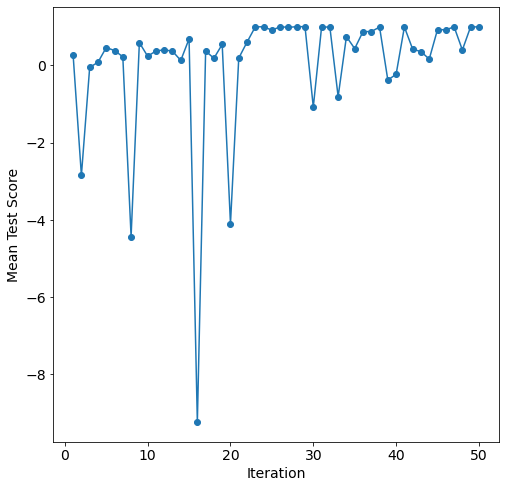

In [14]:
fig, ax = plt.subplots(figsize=(8,8))
ax = tuning.convergence_plot(model_types="nn")

It appears to converge at around the 30th iteration.

## Model Post-processing

With the top `num_configs_saved`, we can pass these parameter configurations to the `PostProcessor` for model comparison and analysis. For `nn` we define the `epochs` parameter to be 200 for better performance.

In [18]:
new_model_settings = {
    "nn": {"epochs": 200}
}
postprocessor = mai.PostProcessor(
    data=data, 
    models_list=[random_search_configs, bayesian_search_configs], 
    new_model_settings=new_model_settings,
)

To compare the performance of these models we will compute 4 metrics for both the training and testing data: 

- mean squared error `MSE` $=\frac{1}{n}\sum^n_{i = 1}(y_i - \hat{y_i})^2$, 
- root mean squared error `RMSE` $=\sqrt{\frac{1}{n}\sum^n_{i = 1}(y_i - \hat{y_i})^2}$,
- mean absolute error `MAE` = $=\frac{1}{n}\sum^n_{i = 1}|y_i - \hat{y_i}|$,
- and r-squared `R2` $=1 - \frac{\sum^n_{i = 1}(y_i - \hat{y_i})^2}{\sum^n_{i = 1}(y_i - \bar{y_i})^2}$,

where $y$ is the actual outcome, $\bar{y}$ is the average outcome, $\bar{y}$ is the model predicted outcome, and $n$ is the number of observations.

In [19]:
postprocessor.metrics()

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
0,linear,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.999925,0.000958,0.000002,0.001384,0.999933,0.000938,0.000002,0.001309
1,lasso,{'alpha': 0.00012988432428433293},0.999608,0.002504,0.000010,0.003163,0.999619,0.002439,0.000010,0.003129
2,lasso,{'alpha': 0.00015685912889361298},0.999467,0.002934,0.000014,0.003689,0.999483,0.002849,0.000013,0.003648
3,lasso,{'alpha': 0.00017924221039588247},0.999330,0.003301,0.000017,0.004136,0.999350,0.003198,0.000017,0.004088
27,nn,"{'batch_size': 8, 'learning_rate': 0.000637576...",0.999359,0.003299,0.000016,0.004046,0.999349,0.003343,0.000017,0.004091
4,lasso,{'alpha': 0.00018528159028297477},0.999290,0.003401,0.000018,0.004259,0.999311,0.003294,0.000018,0.004208
5,lasso,{'alpha': 0.00020059346282778025},0.999182,0.003657,0.000021,0.004570,0.999207,0.003539,0.000020,0.004515
30,nn,"{'batch_size': 8, 'learning_rate': 0.000676896...",0.998134,0.005989,0.000048,0.006905,0.998114,0.006086,0.000048,0.006964
28,nn,"{'batch_size': 8, 'learning_rate': 0.000691626...",0.998011,0.004212,0.000051,0.007129,0.998108,0.004088,0.000049,0.006976
26,nn,"{'batch_size': 8, 'learning_rate': 0.000607447...",0.996410,0.006889,0.000092,0.009577,0.996821,0.006490,0.000082,0.009042


The top performing models are `linear`, `lasso`, `nn`, and `svr`; however, `rforest` is above 0.90 test r-squared. Given the linear models are the most performant models we can safely saw this data set is linear. We can see that `knn` and `dtree` are overfit given the difference between `Train R2` and `Test R2`.

We can see the hyper-parameter configurations of each top `Test R2` model with the `get_params` function.

In [20]:
for model in model_settings["models"]:
    print(postprocessor.get_params(model_type=model), "\n")

  Model Types  copy_X  fit_intercept n_jobs  positive
0      linear    True           True   None     False 

  Model Types    alpha
0       lasso  0.00013 

  Model Types  max_depth max_features  min_samples_leaf  min_samples_split
0       dtree         16         None                 5                  7 

  Model Types  degree  gamma kernel
0         svr       2  scale   poly 

  Model Types  leaf_size  n_neighbors  p   weights
0         knn          8            7  4  distance 

  Model Types criterion  max_features  min_samples_leaf  min_samples_split  \
0     rforest   poisson             6                 2                  3   

   n_estimators  
0           128   

  Model Types  batch_size  learning_rate mid_num_node_strategy  num_layers  \
0          nn           8       0.000638              constant           2   

   start_num_nodes  
0              300   



We can better visualize the performance of each model with diagonal validation plots.

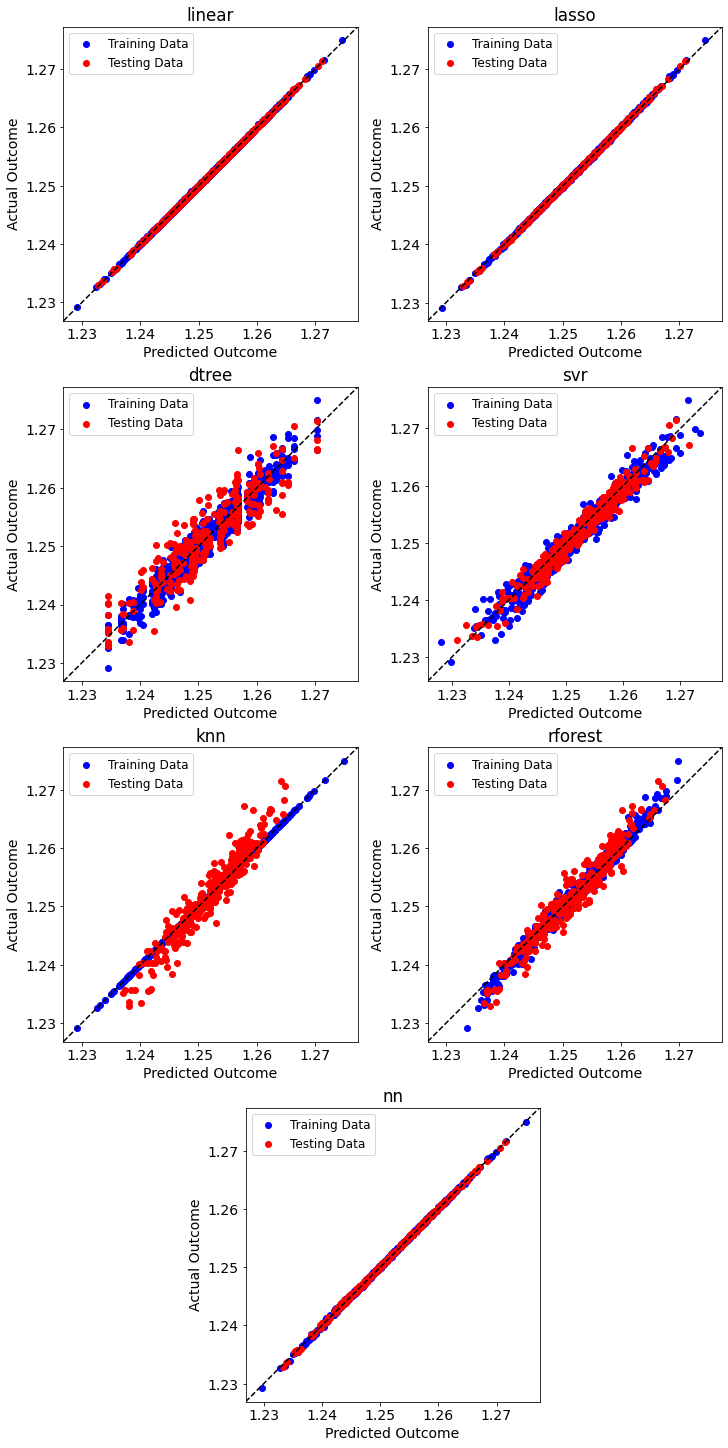

In [21]:
models = np.array([["linear", "lasso"], ["dtree", "svr"], ["knn", "rforest"], ["nn", None]])

fig = plt.figure(constrained_layout=fig, figsize=(10,20))
gs = GridSpec(models.shape[0], models.shape[1], figure=fig)
for i in range(models.shape[0] - 1):
    for j in range(models.shape[1]):
        if models[i, j] != None:
            ax = fig.add_subplot(gs[i, j])
            ax = postprocessor.diagonal_validation_plot(model_type=models[i, j], yscaler=preprocessor.yscaler)
            ax.set_title(models[i, j])
ax = fig.add_subplot(gs[-1, :])
ax = postprocessor.diagonal_validation_plot(model_type=models[-1, 0], yscaler=preprocessor.yscaler)
_ = ax.set_title(models[-1, 0])

`linear`, `lasso`, and `nn` are tightly spread near $y = x$. The overfit of `knn` is apparent in the difference in spread of training compared to testing.

Validation plots tell us a similar story.

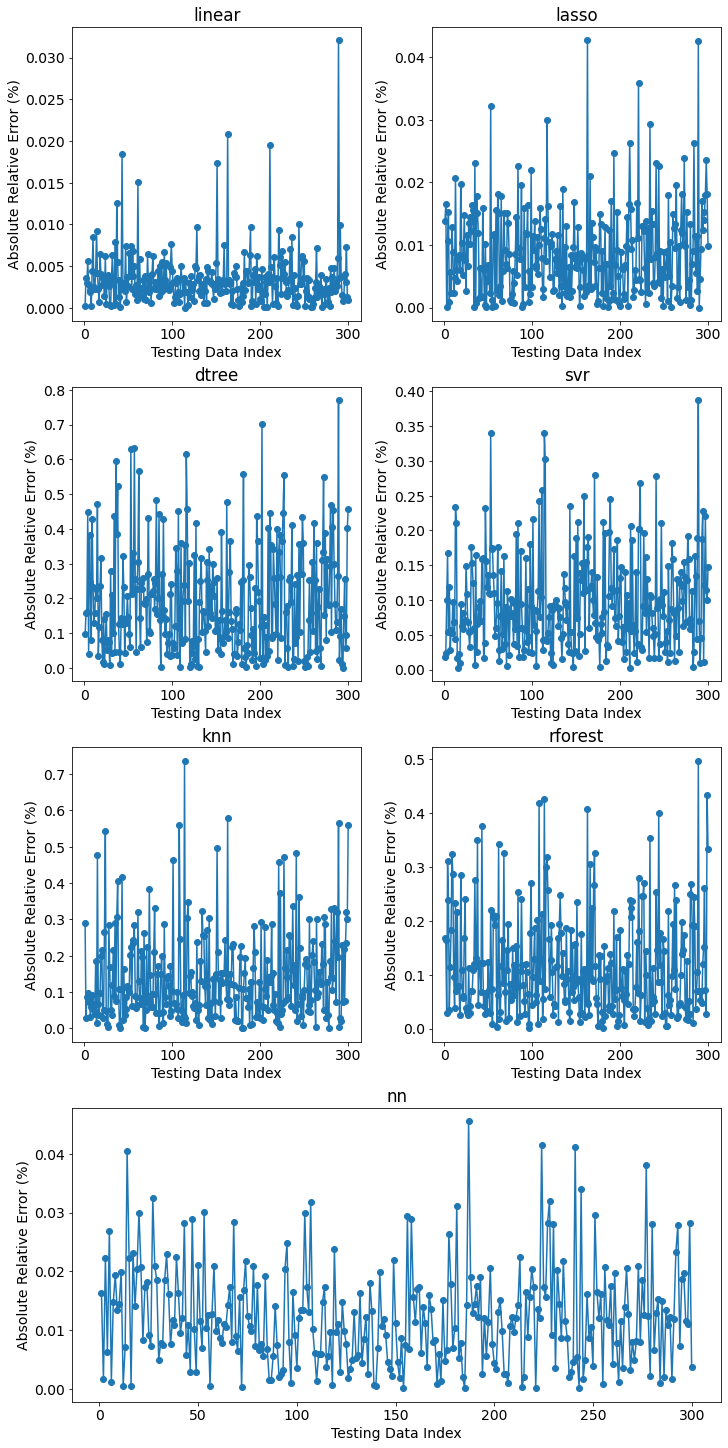

In [22]:
fig = plt.figure(constrained_layout=fig, figsize=(10,20))
gs = GridSpec(models.shape[0], models.shape[1], figure=fig)
for i in range(models.shape[0] - 1):
    for j in range(models.shape[1]):
        if models[i, j] != None:
            ax = fig.add_subplot(gs[i, j])
            ax = postprocessor.validation_plot(model_type=models[i, j], yscaler=preprocessor.yscaler)
            ax.set_title(models[i, j])
ax = fig.add_subplot(gs[-1, :])
ax = postprocessor.validation_plot(model_type=models[-1, 0], yscaler=preprocessor.yscaler)
_ = ax.set_title(models[-1, 0])

`linear`, `lasso`, and `nn` have all testing relative errors less than 0.10.

Finally, we can see if `nn` was overfit in learning curves.

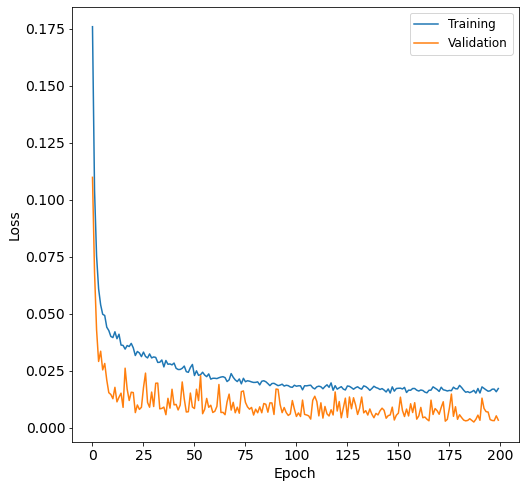

In [23]:
fig, ax = plt.subplots(figsize=(8,8))
ax = postprocessor.nn_learning_plot()

The validation curve is below the training curve; therefore, this `nn` was not overfit.

## References

1. M. I. Radaideh, S. Surani, D. O’Grady, and T. Kozlowski, “Shapley effect application for variance-based sensitivity analysis of the few-group cross-sections,” Annals of Nuclear Energy, vol. 129, pp. 264–279, 2019.

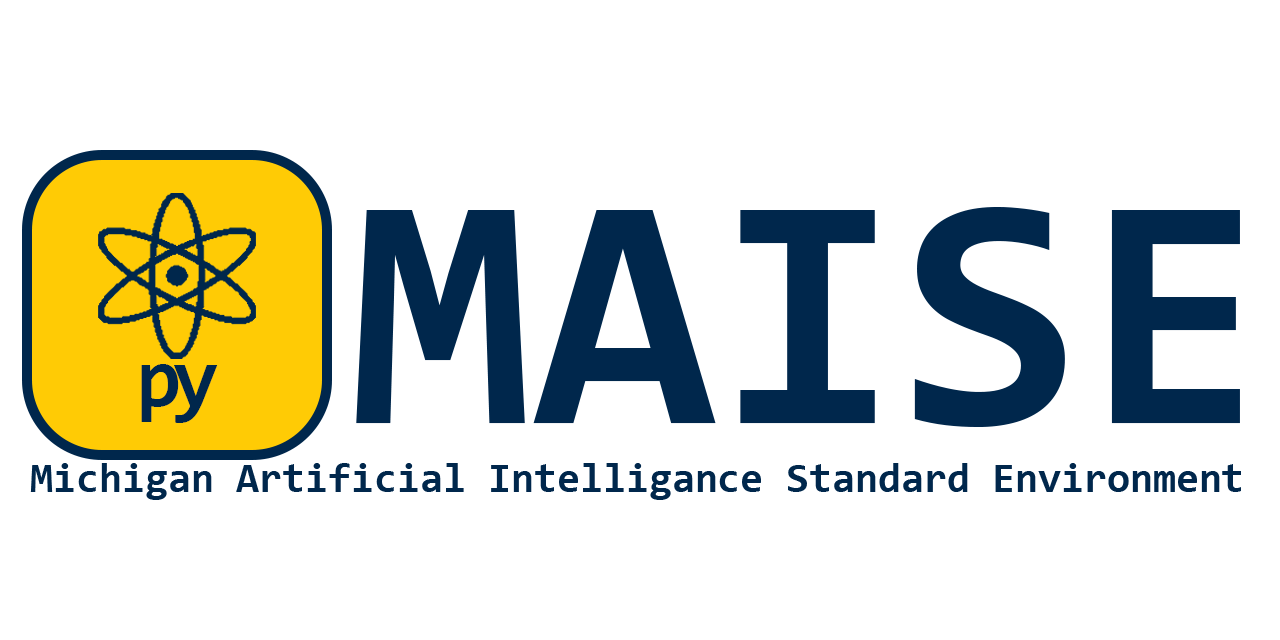